In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tf-roberta/config-roberta-base.json
/kaggle/input/tf-roberta/vocab-roberta-base.json
/kaggle/input/tf-roberta/pretrained-roberta-base.h5
/kaggle/input/tf-roberta/merges-roberta-base.txt
/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/news-fakereal/news.csv


In [2]:
news=pd.read_csv('/kaggle/input/news-fakereal/news.csv')
df_true=pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
df_fake=pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

In [3]:
news.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
news["label"]= news["label"].replace('FAKE', 0)
news["label"]= news["label"].replace('REAL', 1)
news['label']=news['label'].astype(np.int8)

In [5]:
news=news.rename(columns={"Unnamed: 0": "id", "label": "target"})

In [6]:
df_true['target']=1

In [7]:
df_true['target']=df_true['target'].astype(np.int8)

In [8]:
df_true.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [9]:
df_true.shape

(21417, 5)

In [10]:
df_fake['target']=0

In [11]:
df_fake['target']=df_fake['target'].astype(np.int8)

In [12]:
df_fake.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [13]:
df_fake['text']=df_fake['title']+" "+df_fake['text']
df_fake=df_fake[["text","target"]]

In [14]:
df_true['text']=df_true['title']+" "+df_true['text']
df_true=df_true[["text","target"]]

In [15]:
news['text']=news['title']+" "+news['text']
news=news[["text","target"]]

In [16]:
#frames=[df_fake,df_true]
#df = pd.concat(frames)
df=news
df.shape

(6335, 2)

In [17]:
df.head()

,text,target
0,You Can Smell Hillary’s Fear Daniel Greenfield...,0
1,Watch The Exact Moment Paul Ryan Committed Pol...,0
2,Kerry to go to Paris in gesture of sympathy U....,1
3,Bernie supporters on Twitter erupt in anger ag...,0
4,The Battle of New York: Why This Primary Matte...,1


In [18]:
df_train=df

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tokenizers
import transformers
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import KFold
import re

In [20]:
MAX_LEN = 64
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 8
LEARNING_RATE = 3e-5
EPOCHS = 3
#TRAINING_FILE = "../input/nlp-getting-started/train.csv"
#TEST_FILE = "../input/nlp-getting-started/test.csv"
ROBERTA_PATH = "../input/tf-roberta"

In [21]:
roberta_tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base', lower_case=True)

In [22]:
train = df[:5335]
test = df[5335:6335]
print("Training samples: {}".format(train.shape[0]))
print("Test samples: {}".format(test.shape[0]))
train.head(5)

Training samples: 5335
Test samples: 1000


,text,target
0,You Can Smell Hillary’s Fear Daniel Greenfield...,0
1,Watch The Exact Moment Paul Ryan Committed Pol...,0
2,Kerry to go to Paris in gesture of sympathy U....,1
3,Bernie supporters on Twitter erupt in anger ag...,0
4,The Battle of New York: Why This Primary Matte...,1


In [23]:
url = "Great paper by Kalchbrenner https://arxiv.org/pdf/1404.2188.pdf?utm_medium=App.net&utm_source=PourOver"

def remove_urls(text):
    re_url = re.compile(r'https?://\S+|www\.\S+')
    return re_url.sub('', text).strip()

print(remove_urls(url))
train['text'] = train['text'].apply(lambda x : remove_urls(x))
test['text'] = test['text'].apply(lambda x : remove_urls(x))

Great paper by Kalchbrenner


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [24]:
html = """<div>
<h1>Hey</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">removed tags</a>
</div>"""
# remove html tags
def remove_html(text):
    re_html = re.compile(r'<.*?>')
    return re_html.sub('', text)

print(remove_html(html))
train['text'] = train['text'].apply(lambda x : remove_html(x)) 
test['text'] = test['text'].apply(lambda x : remove_html(x)) 


Hey
Kaggle 
removed tags



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [25]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text).strip()

print(remove_emoji("Difficult kernel 😔😔"))
train['text'] = train['text'].apply(lambda x: remove_emoji(x))
test['text'] = test['text'].apply(lambda x: remove_emoji(x))

Difficult kernel


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
punct = 'Cristiano. is #king .l'
import string
def remove_puncts(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table).strip()

print(remove_puncts(punct))
train['text'] = train['text'].apply(lambda x: remove_puncts(x))
test['text'] = test['text'].apply(lambda x: remove_puncts(x))

Cristiano is king l


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [27]:
num_classes = train.target.nunique()
num_classes

2

In [28]:
n_train = train.shape[0]
input_ids = np.ones((n_train, MAX_LEN), dtype='int32')
mask = np.zeros((n_train, MAX_LEN), dtype='int32')

# roberta tokenizer
for k in range(train.shape[0]):
    text = train.loc[k, 'text']
    output = roberta_tokenizer.encode_plus(text, max_length=MAX_LEN, pad_to_max_length=True)
    input_ids[k] = output['input_ids']
    mask[k] = output["attention_mask"]

In [29]:
test=test.reset_index()
test.head()

,index,text,target
0,5335,Scientists Say Universe Is Part Of 4th Dimensi...,0
1,5336,Hillary Clinton Raised 45 Million In Latest Qu...,1
2,5337,State Department spokeswoman floats jobs as an...,1
3,5338,GOPs nightmare An Independent Donald Trump CNN...,1
4,5339,ISIS applies chlorine in Aleppo ISIS applies c...,0


In [30]:
n_test = test.shape[0]
input_ids_t = np.ones((n_test, MAX_LEN), dtype='int32')
mask_t = np.zeros((n_test, MAX_LEN), dtype='int32')

# roberta tokenizer
for k in range(test.shape[0]):
    text = test.loc[k, 'text']
    output = roberta_tokenizer.encode_plus(text, max_length=MAX_LEN, pad_to_max_length=True)
    input_ids_t[k] = output['input_ids']
    mask_t[k] = output["attention_mask"]


In [31]:
def create_dataset():
    xtrain = [input_ids, mask]
    xtest = [input_ids_t, mask_t]
    
    ytrain = tf.keras.utils.to_categorical(train['target'].values.reshape(-1, 1))
    return xtrain, ytrain, xtest

In [32]:
xtrain, ytrain, xtest = create_dataset()
print("X train : {0}".format(len(xtrain[0])))
print("Y train : {0}".format(len(ytrain)))
print("X test : {0}".format(len(xtest[0])))

X train : 5335
Y train : 5335
X test : 1000


In [33]:
def build_model():
    roberta = transformers.TFRobertaForSequenceClassification.from_pretrained('roberta-base')
    optim = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=2.0)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    roberta.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return roberta


In [34]:
Folds = 5
kfold = KFold(n_splits=Folds)
predictions = list()

for i, (train_idx, test_idx) in enumerate(kfold.split(xtrain[0])):
    #print("#"*25+"FOLD: "+str(i)+"#"*25)
    xtrain_fold = [xtrain[i][train_idx] for i in range(len(xtrain))]
    xvalid_fold = [xtrain[i][test_idx] for i in range(len(xtrain))]
    
    ytrain_fold = ytrain[train_idx]
    yvalid_fold = ytrain[test_idx]
    
    # class weights to deal with class imbalance
    positive = train.iloc[train_idx, :].target.value_counts()[0]
    negative = train.iloc[train_idx, :].target.value_counts()[1]
    pos_weight = positive / (positive + negative)
    neg_weight = negative / (positive + negative)

    class_weight = [{0:pos_weight, 1:neg_weight}, {0:neg_weight, 1:pos_weight}]
    
    tf.keras.backend.clear_session()
    
    roberta = build_model()
    roberta.fit(xtrain_fold, ytrain_fold, 
                batch_size=TRAIN_BATCH_SIZE, 
                epochs=EPOCHS, 
                class_weight=class_weight,
                validation_data=(xvalid_fold, yvalid_fold))
    val_preds = roberta.predict(xvalid_fold, batch_size=VALID_BATCH_SIZE, verbose=1)
    val_preds = np.argmax(val_preds, axis=1).flatten()
    print(metrics.accuracy_score(train.iloc[test_idx, :].target.values, val_preds))

    preds = roberta.predict(xtest, batch_size=TRAIN_BATCH_SIZE, verbose=1)
    predictions.append(preds)



Train on 4268 samples, validate on 1067 samples
Epoch 1/3
4268/4268 [==============================] - 59s 14ms/sample - loss: 0.4434 - accuracy: 0.8881 - val_loss: 0.1805 - val_accuracy: 0.9396
Epoch 2/3
4268/4268 [==============================] - 38s 9ms/sample - loss: 0.3324 - accuracy: 0.8785 - val_loss: 0.1931 - val_accuracy: 0.9367
Epoch 3/3
1067/1067 [==============================] - 9s 8ms/sample
0.971883786316776
1000/1000 [==============================] - 3s 3ms/sample
Train on 4268 samples, validate on 1067 samples
Epoch 1/3
4268/4268 [==============================] - 60s 14ms/sample - loss: 0.6167 - accuracy: 0.8431 - val_loss: 0.1956 - val_accuracy: 0.9499
Epoch 2/3
4268/4268 [==============================] - 38s 9ms/sample - loss: 0.1894 - accuracy: 0.9549 - val_loss: 0.0828 - val_accuracy: 0.9831
Epoch 3/3
1067/1067 [==============================] - 9s 9ms/sample
0.9737582005623243
1000/1000 [==============================] - 3s 3ms/sample
Train on 4268 samples, v

In [35]:
predictions = np.average(predictions, axis=0)
predictions = np.argmax(predictions, axis=1).flatten()

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "Blues",linecolor = 'black', annot=annot, fmt='', ax=ax)

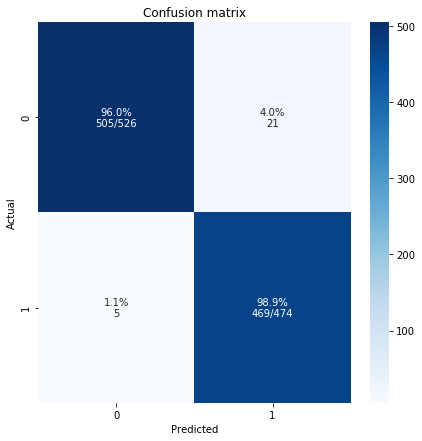

In [37]:
plot_cm(test['target'].values,predictions, 'Confusion matrix', figsize=(7,7))

In [38]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [39]:
cm1=confusion_matrix(test['target'].values,predictions, labels=[0,1])
cm1

array([[505,  21],
       [  5, 469]])

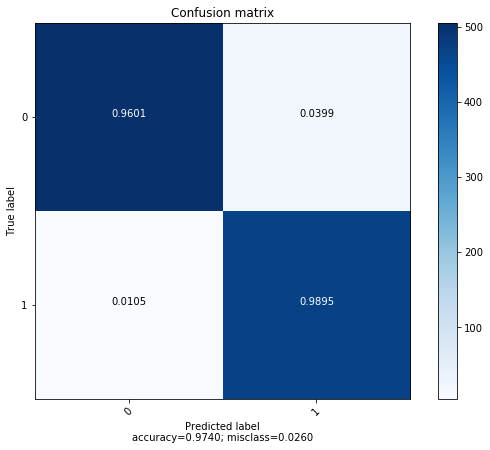

In [40]:
plot_confusion_matrix(cm1,
                          target_names=[0,1],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)